In [1]:
import numpy as np
import pandas as pd
import dill
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.regressor import ResidualsPlot

# Overview

This is the continuation of the analysis of Chicago apartments.com data from may of 2022. In the previous EDA using R,
the dataset was pre-processed and cleaned to be suitable for prediction. Then, a basic LASSO regression was performed on
the log transformed sqft. In the end, the linear model was not flexible enough to capture the trend in the data, since
the residual plot showed clear deviation as the sqft gets larger. Thus, more flexible models are attempted here to see if
better results can be achieved.

# Preparing the data

Most of the pre-processing work has already been done in the previous analysis. Thus, in this analysis the train and test
set from the previous analysis were loaded directly.

In [2]:
seed = 93
random.seed(seed)
np.random.seed(seed)
sqft_train = pd.read_csv("sqft_train.csv")
sqft_test = pd.read_csv("sqft_test.csv")
print(sqft_train.columns)

Index(['air.level', 'base.num', 'baths', 'beds', 'busi.level', 'covered.fee',
       'garage.fee', 'has.covered', 'has.garage', 'has.lot', 'has.street',
       'lot.fee', 'neighborhood', 'pet.allowed', 'pet.deposit', 'pet.fee',
       'pet.rent', 'shopping.num', 'sqft', 'traffic.level', 'zip', 'lat',
       'lng', 'has.parking', 'bed_count', 'bath_count', 'has.pub.elementary',
       'has.priv.elementary', 'has.pub.mid', 'has.cha.high', 'has.priv.high',
       'count.pub.high', 'pub.elt.mid', 'priv.elt.mid', 'has.cha.mid.high',
       'has.priv.mid.high', 'has.pub.mid.high', 'priv.el.hi', 'cha.elt.mid.hi',
       'priv.elt.mid.hi', 'PC1', 'PC2', 'PC3', 'PC4'],
      dtype='object')


Since the data export did not encode the categorical variables, all the categorical variables are encoded into
binary form. The categorical bed_count and bath_count, while useful in the linear regression model,
are duplicate information for the tree based models. Thus, they are dropped as well.

In [3]:
sqft_train = sqft_train.drop(["bed_count", "bath_count"], axis=1)
sqft_test = sqft_test.drop(["bed_count", "bath_count"], axis=1)

sqft_tr_X = sqft_train.loc[:, sqft_train.columns != "sqft"]
sqft_tr_Y = sqft_train.loc[:, "sqft"]
sqft_ts_X = sqft_test.loc[:, sqft_test.columns != "sqft"]
sqft_ts_Y = sqft_test.loc[:, "sqft"]

categories = [
    'air.level', 'base.num', 'busi.level', 'has.covered', 'has.garage',
    'has.lot', 'has.street', 'neighborhood', 'pet.allowed',
    'traffic.level', 'has.parking', 'has.pub.elementary',
    'has.priv.elementary', 'has.pub.mid', 'has.cha.high',
    'has.priv.high', 'count.pub.high', 'pub.elt.mid',
    'priv.elt.mid', 'has.cha.mid.high', 'has.priv.mid.high', 'has.pub.mid.high',
    'priv.el.hi', 'cha.elt.mid.hi', 'priv.elt.mid.hi', "zip"
]

sqft_tr_X = pd.get_dummies(sqft_tr_X, columns=categories)
sqft_ts_X = pd.get_dummies(sqft_ts_X, columns=categories)

for c in sqft_tr_X.columns:
    if c not in sqft_ts_X.columns:
        sqft_ts_X[c] = 0
for c in sqft_ts_X.columns:
    if c not in sqft_tr_X.columns:
        sqft_tr_X[c] = 0

sqft_tr_X = sqft_tr_X.reindex(sorted(sqft_tr_X.columns), axis=1)
sqft_ts_X = sqft_ts_X.reindex(sorted(sqft_ts_X.columns), axis=1)

# Feature Selection

A random forest was fitted over all the training set with the number of trees selected by cross validation. Then, the feature importance was computed from the random forest. From the CV performance, while 200 trees was the optimal, the performance seems to have stabilized around 100 trees. Although the RF feature importance metric is biased towards higher cardinality, the categorical variables are already converted to indicator form, so all categorical variables used for the splits have a cardinality of 2. Furthermore, since the algorithm has to be re-run for each fold for CV later, using the feature importance from RF saves some computation compared to other metrics such as permutation feature importance.

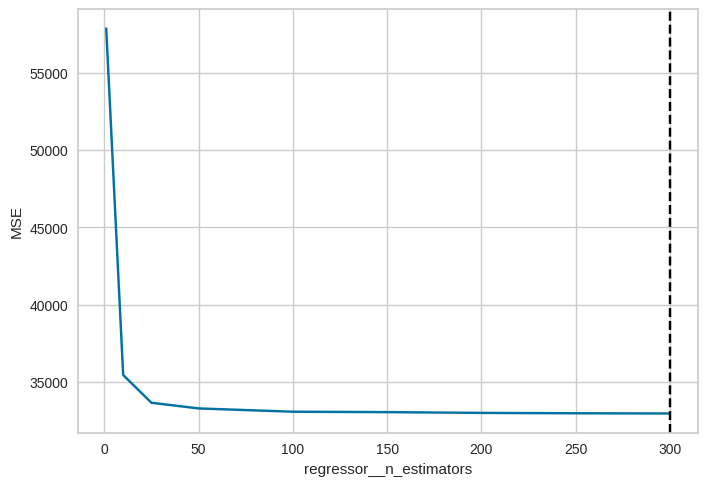

In [4]:
def plot_cv(cv_result, cv, param, x):
    plt.plot(x, -cv_result["mean_test_score"])
    plt.ylabel("MSE")
    plt.xlabel(param)
    plt.axvline(cv.best_params_[param],
            linestyle="--", color="black", label="best")
    plt.show()


rf_full = TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=seed))
params = {
    "regressor__n_estimators": [1, 10, 25] + list(range(50, 301, 50))
}
random_tree_cv = GridSearchCV(estimator=rf_full, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv = random_tree_cv.fit(sqft_tr_X, sqft_tr_Y)
plot_cv(pd.DataFrame(random_tree_cv.cv_results_), random_tree_cv, "regressor__n_estimators", [1, 10, 25] + list(range(50, 301, 50)))

For the actual models for prediction, cross validation would be used to select the hyperparameter as well as the number of top features to use. The random forest feature selection would be added to the pipeline before cross validation with the chosen number of trees to avoid leakage.

In [5]:
def rf_feature_selection(training_set, sqft):
    rf_selector = TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=seed, n_estimators=200),
                                             func=np.log, inverse_func=np.exp)
    rf_selector.fit(training_set, sqft)
    return rf_selector.regressor_.feature_importances_


def perf_summary(model, tr_x, ts_x, tr_y, ts_y):
    tr = model.predict(tr_x)
    ts = model.predict(ts_x)

    tr_mse = mean_squared_error(tr_y, tr)
    ts_mse = mean_squared_error(ts_y, ts)
    tr_mae = mean_absolute_error(tr_y, tr)
    ts_mae = mean_absolute_error(ts_y, ts)
    ts_mean = np.mean(ts - ts_y)
    ts_std = np.std(ts - ts_y)

    perf = pd.Series([tr_mse, ts_mse, tr_mae, ts_mae, ts_mean, ts_std],
                    index=["train.mse", "test.mse", "train.mae", "test.mae",
                           "test.resid.mean", "test.resid.stdev"])
    return perf


k_best = SelectKBest(rf_feature_selection)

# Prediction
With the features selection process described, several models are fitted, and their results are reported below.

## Random Forest

Since removing the noise features increases the chance that a relevant feature would be picked by the rf, the random forest model was fitted with the random forest feature selection.

In [6]:
rf_pipeline = Pipeline(steps=[("feature_select", k_best), ("rf", RandomForestRegressor(random_state=seed))])
rf_pipeline = TransformedTargetRegressor(regressor=rf_pipeline)

params = {
    "regressor__rf__n_estimators": [1] + list(range(50, 301, 50)),
    "regressor__feature_select__k": [20, 50, 100, 150, 200]
}

random_tree_cv = GridSearchCV(estimator=rf_pipeline, param_grid=params, n_jobs=-1,
                              cv=10, scoring="neg_mean_squared_error")
random_tree_cv.fit(sqft_tr_X, sqft_tr_Y)

GridSearchCV(cv=10,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_select',
                                                                             SelectKBest(score_func=<function rf_feature_selection at 0x7fe157f125f0>)),
                                                                            ('rf',
                                                                             RandomForestRegressor(random_state=93))])),
             n_jobs=-1,
             param_grid={'regressor__feature_select__k': [20, 50, 100, 150,
                                                          200],
                         'regressor__rf__n_estimators': [1, 50, 100, 150, 200,
                                                         250, 300]},
             scoring='neg_mean_squared_error')

The CV performance of the optimal random forest is shown below. A total of 150 features with 200 trees resulted in the optimal performance. The end performance seems to be similar to the random forest without feature selection. Thus, the random forest seems to be resistant against potentially irrelevant features for this dataset.

In [7]:
def best_cv(cv):
    cv_result = pd.DataFrame(cv.cv_results_)
    return cv_result, cv_result.loc[cv_result.rank_test_score == 1,
                 ["params", "mean_test_score", "std_test_score"]]


cv_rf_result, best_rf_result = best_cv(random_tree_cv)
best_rf_result

,params,mean_test_score,std_test_score
13,"{'regressor__feature_select__k': 50, 'regresso...",-32860.720155,4565.10864


The MSE for each of the combinations of the hyperparameters are plotted in the heatmap below. It seems that with the number of features starting from 20, the number of trees in the RF played a bigger role. Furthermore, the performance are fairly similar when there are at least 50 trees in the forest.

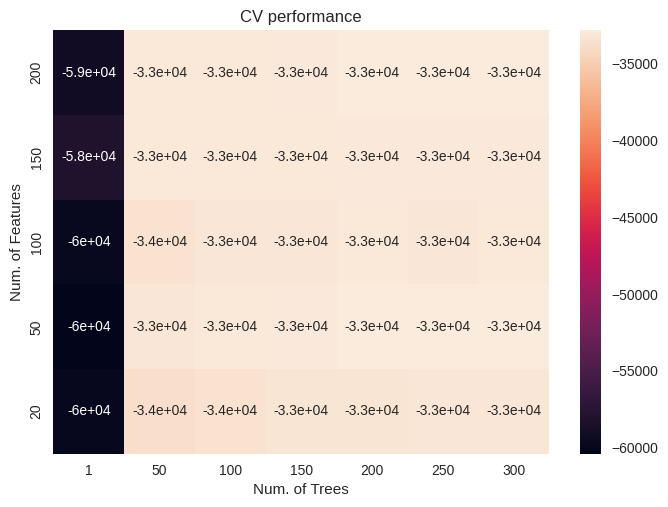

In [8]:
def create_heatmap_df(cv_result, param_name_row, param_name_col):
    column_index = {}
    row_length = len(cv_result.param_grid[param_name_row])
    for col in cv_result.param_grid[param_name_col]:
        column_index[col] = [np.nan] * row_length
    row_arr_index = dict([(v, row_length - i - 1) for i, v in enumerate(cv_result.param_grid[param_name_row])])

    for i, param in enumerate(cv_result.cv_results_["params"]):
        param_row = param[param_name_row]
        param_col = param[param_name_col]

        column_index[param_col][row_arr_index[param_row]] = cv_result.cv_results_["mean_test_score"][i]

    row_index = [-1] * row_length
    for k, v in row_arr_index.items():
        row_index[v] = k

    heatmap_df = pd.DataFrame(column_index, index=row_index)
    return heatmap_df


param_name_row = "regressor__feature_select__k"
param_name_col = "regressor__rf__n_estimators"
heatmap_df = create_heatmap_df(random_tree_cv, param_name_row, param_name_col)
sns.heatmap(heatmap_df, annot=True, annot_kws={"size": 10})
plt.xlabel("Num. of Trees")
plt.ylabel("Num. of Features")
plt.title("CV performance")
plt.show()

The residuals of the optimal model is plotted below. Notably, the yellowbrick implementation of the residual plot seems to define residual as predicted - observed. It seems that perhaps due to some large apartments intermixed with a large amount of smaller apartments with similar attributes, the model was not able to adjust for the larger size. This is also reflected in the histogram of the residuals with a slightly longer tail towards the negatives.

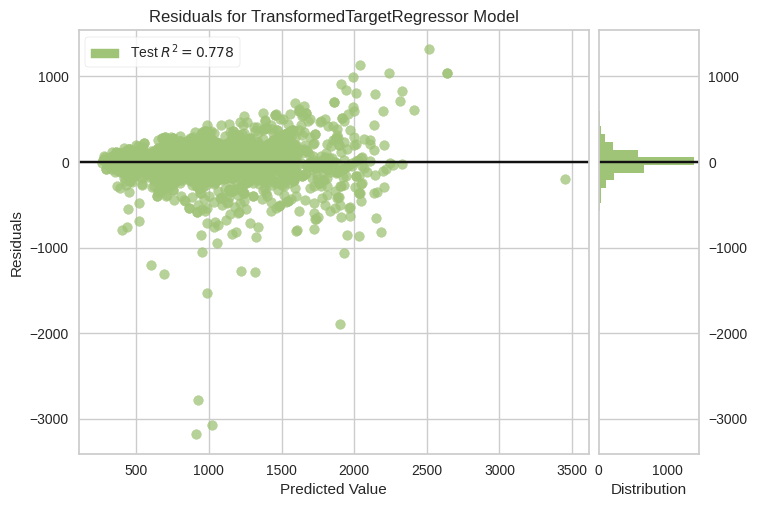

<AxesSubplot:title={'center':'Residuals for TransformedTargetRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [9]:
best_rf = random_tree_cv.best_estimator_
rs_plot = ResidualsPlot(best_rf, hist=True)
rs_plot.score(sqft_ts_X, sqft_ts_Y)
rs_plot.show()

The performance of the 200 tree random forest on the test set is summarized below. Both the mse and the mae increased notably
from the training set to the test set. The MAE on the test is 105 sqft, while the MSE is 30496. The residual mean is around -6 sqft, which also suggests that the estimator slightly under-predict
the data overall.

In [10]:
rf_perf = perf_summary(best_rf, sqft_tr_X, sqft_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
rf_perf

train.mse            7392.344217
test.mse            40986.295591
train.mae              53.283085
test.mae              111.103150
test.resid.mean        -4.941520
test.resid.stdev      202.390407
dtype: float64

## Adaboost

Adaboost is also fitted on the training set. The algorithm incrementally optimizes the loss function using a base estimator 
by re-weighting the samples such that the next estimator focuses more on the bad outputs from the previous estimators. 
Then, it also does a weighted average of all the estimators with weights calculated to minimize the loss.

Here, the decision tree is used as a base estimator. Since the data is not linear, the max depth of the decision tree is 
increased to 25 so that it can successfully fit to the more challenging samples. The loss function is chosen to be the 
standard square loss, and the number of estimator is selected to be the one that performed best in cross validation. 

In [11]:
adaboost_pipe = Pipeline(steps=[("feature_select", k_best), ("ada", AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, random_state=seed), random_state=seed,
                             loss="square"))])
adaboost_param = {
    "ada__n_estimators": range(1, 61, 5),
    "feature_select__k": [20, 50, 100, 150, 200]
}
adaboost_cv = GridSearchCV(adaboost_pipe, adaboost_param, n_jobs=-1,
                          cv=10, scoring="neg_mean_squared_error")
adaboost_cv.fit(sqft_tr_X, sqft_tr_Y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_select',
                                        SelectKBest(score_func=<function rf_feature_selection at 0x7fe157f125f0>)),
                                       ('ada',
                                        AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                                               random_state=93),
                                                          loss='square',
                                                          random_state=93))]),
             n_jobs=-1,
             param_grid={'ada__n_estimators': range(1, 61, 5),
                         'feature_select__k': [20, 50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

The cross validation performance for adaboost is shown below. The mean test mse is 36633, which is slightly higher
than the 36286 of random forest. The standard error is at 7069, which is also higher than the random forest at 5345.
Since both the random forest and adaboost are fairly flexible, they have low bias. Thus, the better mean mse and standard deviation of the
random forest may be due to the fact that it is designed to reduce the variance of the predictor.

In [12]:
adaboost_cv_result, best_ada_res = best_cv(adaboost_cv)
best_ada_res

,params,mean_test_score,std_test_score
39,"{'ada__n_estimators': 36, 'feature_select__k':...",-34600.383611,5714.520601


The CV curve is shown below. The optimal number of estimator was at 41 with 150 features. Unlike rf, Adaboost starts to
overfit to the data after around 46 trees, since the mse starts to increase.

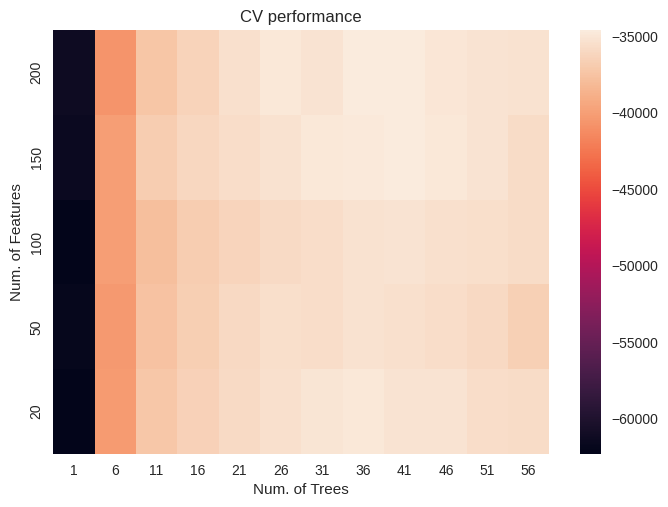

In [13]:
param_name_row = "feature_select__k"
param_name_col = "ada__n_estimators"
heatmap_df = create_heatmap_df(adaboost_cv, param_name_row, param_name_col)
sns.heatmap(heatmap_df)
plt.xlabel("Num. of Trees")
plt.ylabel("Num. of Features")
plt.title("CV performance")
plt.show()

The residual plot of the Adaboost is similar to the random forest. It is still the case where there are cases of large under-estimation of the square feets.

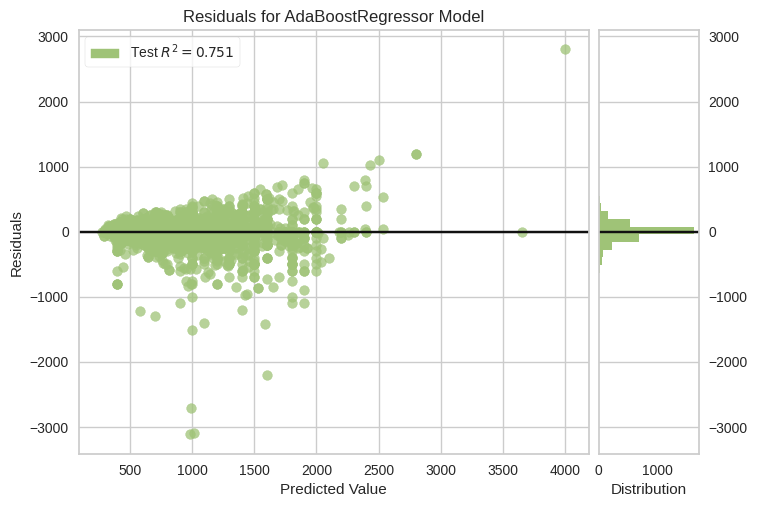

<AxesSubplot:title={'center':'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [14]:
best_ada = adaboost_cv.best_estimator_
rs_plot = ResidualsPlot(best_ada, hist=True)
rs_plot.score(sqft_ts_X, sqft_ts_Y)
rs_plot.show()

The performance of adaboost on the test set is summarized below. It's pretty similar to the performance of random forest. The test residual mean is approx -11, which means a slightly greater under-estimation than the random forest.

In [15]:
ada_perf = perf_summary(best_ada, sqft_tr_X, sqft_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
ada_perf

train.mse            8815.419901
test.mse            46031.801151
train.mae              53.975558
test.mae              114.777294
test.resid.mean       -10.892290
test.resid.stdev      214.273562
dtype: float64

## Bagged Adaboost

By explicitly reducing the variance of Adaboost via bagging, the performance may be improved further.
Since cross validation was already performed for Adaboost, the same parameters are used here. The number of estimators are selected
via cross validation.

In [16]:
bag_ada_params = {
    "bag_ada__n_estimators": range(1, 101, 10),
    "feature_select__k": [20, 50, 100, 150, 200]
}
bag_ada_base = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, random_state=seed), random_state=seed,
                             loss="square", n_estimators=46)
bag_ada = BaggingRegressor(bag_ada_base, random_state=seed)
bag_ada_pipe = Pipeline(steps=[("feature_select", k_best), ("bag_ada", bag_ada)])
bag_ada_cv = GridSearchCV(estimator=bag_ada_pipe, param_grid=bag_ada_params, n_jobs=-1,
                          cv=10, scoring="neg_mean_squared_error")
bag_ada_cv.fit(sqft_tr_X, sqft_tr_Y)

/home/sdai/PycharmProjects/Analysis/venv37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_select',
                                        SelectKBest(score_func=<function rf_feature_selection at 0x7fe157f125f0>)),
                                       ('bag_ada',
                                        BaggingRegressor(base_estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                                                                               random_state=93),
                                                                                          loss='square',
                                                                                          n_estimators=46,
                                                                                          random_state=93),
                                                         random_state=93))]),
             n_jobs=-1,
             param_grid={'bag_ada__n_estimators

It turned out that only 21 adaboost estimators, each trained on 50 features achieved the optimal mse. From the CV
result, bagging indeed improved the performance of Adaboost. The bagged estimator is able to achieve a mean test 
score of 33928, and a standard error of 5279, which are both lower than the plain adaboost and random forest results. Thus,
the bagging seemed to have lead to a reduction in variance, which lead to a reduction in expected error.

In [17]:
bag_ada_cv_cv_result, best_bag_ada = best_cv(bag_ada_cv)
best_bag_ada

,params,mean_test_score,std_test_score
41,"{'bag_ada__n_estimators': 81, 'feature_select_...",-32707.036794,5159.263063


The cross validation performance of bagged adaboost is similar to random forest, where after 11 estimators in the group, the performance improved notably from just 1 estimator.

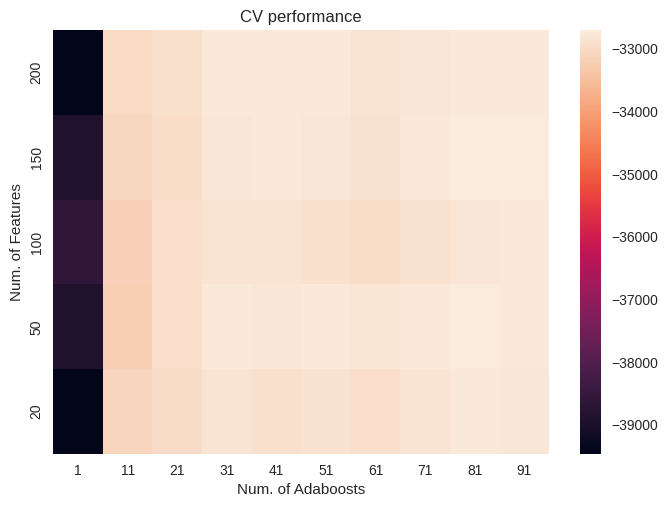

In [18]:
param_name_row = "feature_select__k"
param_name_col = "bag_ada__n_estimators"
heatmap_df = create_heatmap_df(bag_ada_cv, param_name_row, param_name_col)
sns.heatmap(heatmap_df)
plt.xlabel("Num. of Adaboosts")
plt.ylabel("Num. of Features")
plt.title("CV performance")
plt.show()

The residual plot is very similar to the previous ones. There's still a general under estimation for some of the larger apartments.

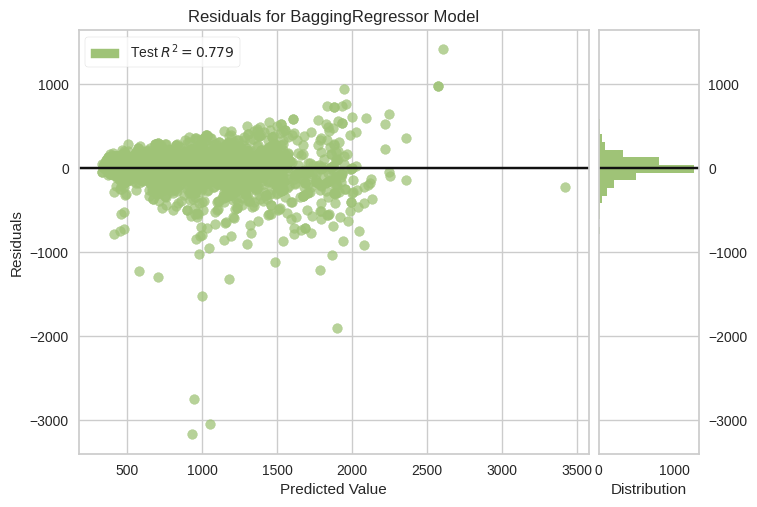

<AxesSubplot:title={'center':'Residuals for BaggingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [19]:
best_ada_bag = bag_ada_cv.best_estimator_
rs_plot = ResidualsPlot(best_ada_bag, hist=True)
rs_plot.score(sqft_ts_X, sqft_ts_Y)
rs_plot.show()

The performance of the bagged adaboost on the test set is summarized here. It achieved a similar test MAE as
the other estimators. The under-estimation of the sqfts are similar with the plain adaboost, and the standard deviation
of the residuals are comparable with the other estimators.

In [20]:
ada_perf = perf_summary(best_ada_bag, sqft_tr_X, sqft_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
ada_perf

train.mse           12251.172393
test.mse            40886.291910
train.mae              72.783425
test.mae              115.569294
test.resid.mean        -8.050037
test.resid.stdev      202.043284
dtype: float64

## Stacked Estimator

A final stacked estimator consisting of the random forest, plain adaboost, and bagged adaboost are fitted to the 
training set. The final prediction is the output of a ridge regression on the output of the three base estimators. 
Thus, it can balance out the performance of the different estimators to achieve a weighted averge of all 3 estimator 
with less variance and better accuracy. As usual, the tuning parameter is set via cross validation.

In [21]:
estimators = {
    "rf": best_rf,
    "ada": best_ada,
    "bag_ada": best_ada_bag
}
stacking_ridge = StackingRegressor(estimators=list(estimators.items()), cv=10,
                                   n_jobs=-1, passthrough=False)

The cross validation performance of the stacked estimators is shown below. The ensemble estimator achieved the lowest 
mean test error and standard error of all the estimators so far. Thus, the stacking was able to improve the 
performance of the estimators.

In [22]:
stacking_cv = cross_val_score(stacking_ridge, sqft_tr_X, sqft_tr_Y,
                              cv=10, scoring="neg_mean_squared_error", n_jobs=-1)
pd.Series([stacking_cv.mean(), stacking_cv.std()], ["cv_mean", "cv_std"])

/home/sdai/PycharmProjects/Analysis/venv37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


cv_mean   -32091.746355
cv_std      4896.249483
dtype: float64

The residual plot of the stacked predictor is almost identical to the bagged adaboost plot. Thus, stacking was not effective in addressing the large units as with the other estimators.

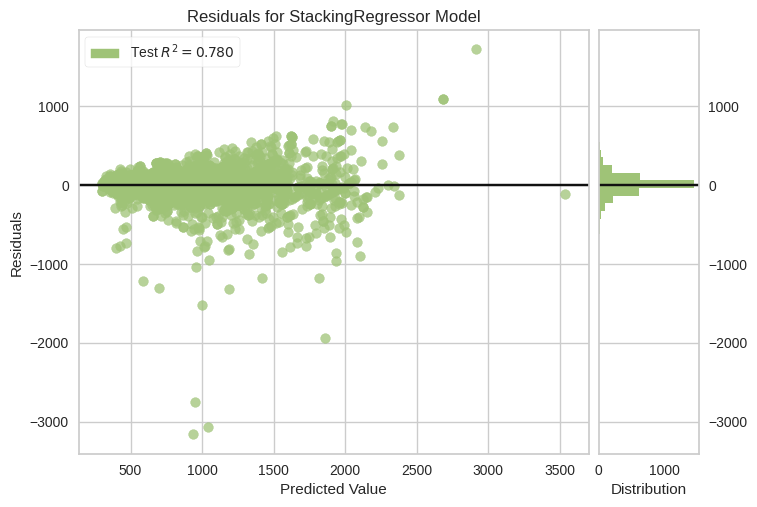

<AxesSubplot:title={'center':'Residuals for StackingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [23]:
stacking_ridge.fit(sqft_tr_X, sqft_tr_Y)
rs_plot = ResidualsPlot(stacking_ridge, hist=True)
rs_plot.score(sqft_ts_X, sqft_ts_Y)
rs_plot.show()

The stacked predictor achieved the lowerst test MSE of all the tried predictors, and comparable MAE with the other predictors. Furthermore, despite the large units, overall it only had an under-estimation of 5 sqft on average on the test set. Thus, it was able to make an improvement on the under-estimation from the previous predictors.

In [24]:
stacking_perf = perf_summary(stacking_ridge, sqft_tr_X, sqft_ts_X,
                       sqft_tr_Y, sqft_ts_Y)
stacking_perf

train.mse            8466.940307
test.mse            40723.922357
train.mae              60.529119
test.mae              112.221828
test.resid.mean        -3.960333
test.resid.stdev      201.762826
dtype: float64

# Conclusion

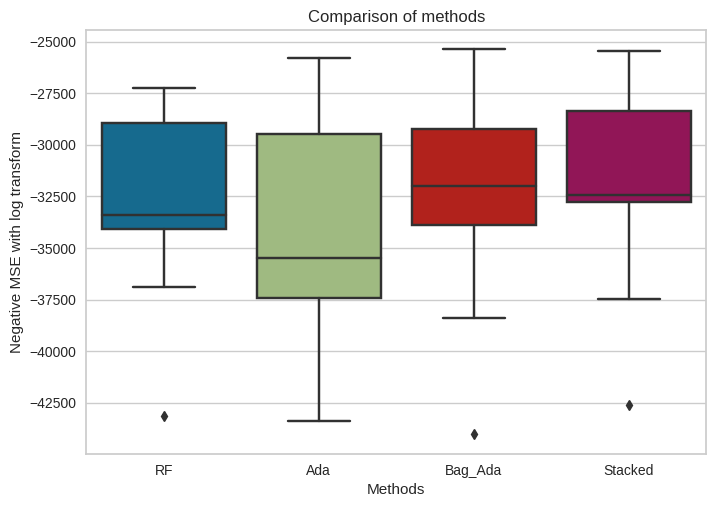

In [25]:
rf_df = cv_rf_result.loc[cv_rf_result.rank_test_score == 1, ].iloc[:, 7:17].transpose().set_axis(["RF"], axis=1, inplace=False)
ada_df = adaboost_cv_result.loc[adaboost_cv_result.rank_test_score == 1, ].iloc[:, 7:17].transpose().set_axis(["Ada"], axis=1, inplace=False)
bag_ada_df = bag_ada_cv_cv_result.loc[bag_ada_cv_cv_result.rank_test_score == 1, ].iloc[:, 7:17].transpose().set_axis(["Bag_Ada"], axis=1, inplace=False)
combined_temp = rf_df.join(ada_df).join(bag_ada_df).reset_index(drop=True)
combined_temp = combined_temp.join(pd.DataFrame(stacking_cv).set_axis(["Stacked"], axis=1, inplace=False))
fig = sns.boxplot(x="variable", y="value", data=pd.melt(combined_temp))
plt.xlabel("Methods")
plt.ylabel("Negative MSE with log transform")
plt.title("Comparison of methods")
plt.show()

From the boxplot above as well as the individual summaries under each section, the stacked predictor and the bagged adaboost have a better performance over the random forest and plain adaboost. From the boxplot, the bagged adaboost, and random forest have similar spread in cross validation performance. While the stacked estimator had comparable standard deviation with the random forest and bagged adaboost, its spread from the boxplot seems to be comparable to the adaboost by itself. Thus, on this dataset, bagging was fairly effective in having a lower spread and standard deviation in performance.

Since the stacked predictor had the best performance in cross validation with a comparable standard deviation, it will be used to better fill in the square feet information on incomplete records. All the required predictors would be fitted on the whole dataset where square feet is not absent. The hyperparameters selected from before are used for the feeder predictors, while the hyperparameter for the ridge stacked regressor would be picked via cross validation on the whole dataset. Then, the square feet for the missing records will be calculated with the fitted model


In [26]:
full_set = pd.concat([sqft_tr_X, sqft_ts_X], ignore_index=True)
full_log_sqft = pd.concat([sqft_tr_Y, sqft_ts_Y], ignore_index=True)
full_set.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'air.level_Active', 'air.level_Busy',
       'air.level_Calm', 'base.num_True', 'baths', 'beds',
       ...
       'zip_60659', 'zip_60660', 'zip_60661', 'zip_60674', 'zip_60706',
       'zip_60707', 'zip_60714', 'zip_60803', 'zip_60804', 'zip_60805'],
      dtype='object', length=287)

In [27]:
stacking_ridge = stacking_ridge.fit(full_set, full_log_sqft)
with open("final_sqft_mod.joblib", "wb") as file:
    dill.dump(stacking_ridge ,file)